## Introduction:
The goal of this Notebook is to implement a simple model-based reinforcement learning algorithm.  First we will learn a dynamics function to model observed state transitions, and then we will use model predictions directly in an optimization setup to maximize predicted rewards, we will call this step the process of creating a controller. If you want to read more about this topic then you can read this [paper](https://arxiv.org/pdf/1708.02596.pdf)

Before we start, we install some necessary packages to visualise the network

In [ ]:
!pip install graphviz
!pip install pydot
!pip install gym
!python -m pip install git+https://github.com/tensorflow/docs

In [ ]:
!pip install tensorflow-datasets

## Developing an RL cycle using OpenAI GYM
`Gym` is a toolkit for developing and comparing reinforcement learning algorithms. `Gym` has a lot of built-in environments like the cartpole, pendulum,... In this [link](https://gym.openai.com/envs/), you can find a list of all defined environments.

<img src=img/notebook2/rl.png width="400">

The following code lets the RL Agent plays for four episodes in which Agent makes 100 moves while the game is rendered at each step and prints the accumulated reward for each game using the following code

In [1]:
import numpy as np 
import gym

# create and initialize the environment
env = gym.make("Pendulum-v0")
env.reset()

array([ 0.9618377 , -0.27362062,  0.3209401 ])

In [2]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
print("the shape of the observation space: ", obs_dim)
print("the shape of the action space: ", act_dim)

the shape of the observation space:  3
the shape of the action space:  1


In [5]:
# play 4 games
number_episodes = 4
number_moves    = 100
for i in range(number_episodes):
    # initialize the environment
    env.reset()
    done = False
    game_rew = 0  # accumulated reward
    for j in range(number_moves):
        # choose a random action
        action = env.action_space.sample()
        # take a step in the environment
        new_obs, rew, done, info = env.step(action)
        game_rew += rew
        env.render()
        # when is done, print the cumulative reward of the game and reset the environment
        if done:
            print("Done")
            break
    print('Episode %d finished, reward:%d, the lenght of the episode:%d'% (i, game_rew,j))
env.close()

Episode 0 finished, reward:-477, the lenght of the episode:99
Episode 1 finished, reward:-883, the lenght of the episode:99
Episode 2 finished, reward:-384, the lenght of the episode:99
Episode 3 finished, reward:-379, the lenght of the episode:99


The environment is initialized by calling `reset()`. After doing so, the cycle loops 10 times. In each iteration, `env.action_space.sample()` samples a random action, executes it in the environment with `env.step()`, and displays the result with the `render()` method; that is, the current state of the game, as in the preceding screenshot. In the end, the environment is closed by calling `env.close()`.  Indeed, the `step()` method returns four variables that provide information about the interaction with the environment; namely, Observation, Reward, Done, and Info.

Whenever `done` is True, this means that the episode has terminated and that the environment should be reset. 

### OpenAI Gym Spaces
The actions and observations are mostly instances of the `Discrete` or `Box` class. These two classes represent different spaces. `Box` represents an n-dimensional array, while `Discrete`, on the other hand, is a space that allows a fixed range of non-negative numbers. The observation of `Pendulum` is encoded by three floats, meaning that it's an instance of the `Box` class and the action space is an instance of the `Box` class.

In [6]:
print("The observation space of Pendulum is ", env.observation_space)
print("The action space of Pendulum is ", env.action_space)

The observation space of Pendulum is  Box(3,)
The action space of Pendulum is  Box(1,)


The `low` and `high` instance attributes return the minimum and maximum values allowed by a `Box` space: 

In [7]:
print("The minimum value of the observation space :", env.observation_space.low)
print("The maximum value of the observation space :", env.observation_space.high)

The minimum value of the observation space : [-1. -1. -8.]
The maximum value of the observation space : [1. 1. 8.]


### OpenAI Gym Wrappers

you will want to extend the environment’s functionality in some generic way. For example, an environment gives you some observations, but you want to accumulate them in some buffer and provide to the agent the N last observations.

Another example is when you want to be able to crop or preprocess an image’s pixels to make it more convenient for the agent to digest, or if you want to normalize reward scores somehow. There are many such situations which have the same structure: you’d like to “wrap” the existing environment and add some extra logic doing something. Gym provides you with a convenient framework for these situations, called a Wrapper class.

In [8]:
class StructEnv(gym.Wrapper):
    '''
    Gym Wrapper to store information like number of steps and total reward of the last espisode.
    '''
    def __init__(self, env,max_rollout_length = 1000):
        gym.Wrapper.__init__(self, env)
        self.n_obs = self.env.reset()
        self._max_rollout_length = max_rollout_length
        self.total_rew = 0
        self.len_episode = 0
        
    def reset(self, **kwargs):
        self.n_obs = self.env.reset(**kwargs)
        self.total_rew = 0
        self.len_episode = 0
        return self.n_obs.copy()
        
    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.total_rew += reward
        self.len_episode += 1
        return ob, reward, done, info
    
    
    def generate_rollout(self,policy, render= False):
        rollout = Rollout()
        state = self.reset()
        done = False
        while not done:
            # Render the environment
            if render:
                env.render()
            # get action'
            action = policy.get_action(state)
            # make env step
            next_state, reward, done, _ = self.step(action)
            done = done or (self.len_episode >= self._max_rollout_length)
            # Save the tranision
            rollout.add(state, action, next_state, reward, done)
            # update the state
            state = next_state
        return rollout
    
    @property
    def get_episode_reward(self):
        return self.total_rew
    @property
    def get_episode_length(self):
        return self.len_episode

Define the environment

In [ ]:
# create and initialize the environment
env = gym.make("Pendulum-v0")
env = StructEnv(env)
env.reset()

In [ ]:
# play 4 games
number_episodes = 4
number_moves    = 100
for i in range(number_episodes):
    # initialize the environment
    env.reset()
    done = False
    for j in range(number_moves):
        # choose a random action
        action = env.action_space.sample()
        # take a step in the environment
        new_obs, rew, done, info = env.step(action)
        game_rew += rew
        env.render()
        # when is done, print the cumulative reward of the game and reset the environment
        if done:
            print("Done")
            break
    print('Episode %d finished, reward:%d, the lenght of the episode:%d' % (i, env.get_episode_reward, env.get_episode_length))
env.close()

## Machine Learning with TF 2.0 (Recap)

As a recap of what we  used in the last exercises 

```python
## Load Dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

## Define the loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

## Create the optimizer by minimizing the loss using the Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr_schedule)

## Compile the model
model.compile(optimizer=optimizer,
              loss=loss_object,
              metrics=['accuracy'])

## Train the model
model.fit(x_train, 
          y_train,
          epochs=3,
          validation_data=(x_test, y_test),
          verbose=1)
```

TensorFlow 2.x comes with some great benefits, one of them is **Eager execution**. TensorFlow 1.x defines static computational graphs. However, Python is typically more dynamic. TensorFlow 2.x  **still defines a graph**, but we can define, change, and execute nodes on-the-fly, with no special session interfaces or placeholders. The **eager execution**  means that the model definitions are dynamic, and the execution is immediate. Another benefit of using TensorFlow 2.x is **Training from `tf.data.datasets`**. The `tf.data` API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

## Model-Based Reinforcement Learning with TF 2.0
Model-Based Reinforcement Learning consists primarily of two steps:
1. learning a dynamics model and
2. using the learned dynamics models to plan and execute actions that maximize a reward function or to train a policy (Dyna Style)

The first step is to import all required packages for this notebook

In [9]:
import numpy as np 
import gym
import ml2_utils
from datetime import datetime

import tensorflow as tf
if(int(tf.__version__[0]) <= 1):
    print('tensorflow {} detected; Please install tensorflow >= 2.0.0'.format(tf.__version__))
else:
    print('tensorflow {} detected'.format(tf.__version__))
    
from tensorflow.keras.utils import plot_model


tensorflow 2.2.0 detected


## Dynamics Model
We parameterize our learned dynamics function $f_\theta (s_t, a_t)$ as a deep neural network, where the parameter vector $\theta$ represents the weights of the network. 
We don't want to learn a network to predict the next state $s_{t+1}$, given the current state and the current  action $s_t, a_t$  this function can be difficult to learn when the states $s_t$  and $s_{t+1}$ are too similar and the action has seemingly little effect on the output; this difficulty becomes more pronounced as the time between states $∆t$ becomes smaller and the state differences do not indicate the underlying dynamics well.

Note that increasing this $∆t$ increases the information available from each data point, and can help
with not only dynamics learning but also with planning using the learned dynamics model. However, increasing
$∆t$ also increases the discretization and complexity of the underlying continuous-time dynamics, which can make the learning process more difficult.

We will learn a neural network dynamics model encodes the change in state that occurs as a result of executing the action $a_t$from state $s_t$ of the form:
$$\hat{\Delta}_{t+1} = f_\theta (s_t, a_t)$$
such that
$$ s_{t+1} =  s_t + \hat{\Delta}_{t+1} $$

We will train $f_\theta$ in a standard supervised learning setup, by performing gradient descent on the following objective:
$$L(\theta) =   \sum_{(s_t, a_t,s_{t+1} ) \in D}  \lVert (s_{t+1} − s_t) − fθ(s_t, a_t)\rVert_2^2$$
$$L(\theta) =   \sum_{(s_t, a_t,s_{t+1} ) \in D}  \lVert (\Delta_{t+1} − \hat{\Delta}_{t+1}\rVert_2^2$$


### Collecting training data:

model_buffer is an instance of the FullBuffer class that contains the samples generated by the environment, and generate_random_dataset creates two partitions for training and validation, which are then returned by calling get_training_batch and get_valid_batch.
1. Random Policy: to generate Date for the model
2. Gather Rollouts and save them in buffer
<img src=img/notebook2/data_collection.png width="540">

In [10]:
class RandomPolicy:
    def __init__(self, env):
        self._max_action = self._action_space_low = env.action_space.low
        self._action_space_high = env.action_space.high
        self._act_dim = act_dim
        self.policy_name = "RandomPolicy"

    def get_action(self, state):
        return np.random.uniform(
            low=-self._max_action,
            high=self._max_action,
            size=self._act_dim)

    def get_actions(self, batch_size):
        return np.random.uniform(
            low=-self._max_action,
            high=self._max_action,
            size=(batch_size, self._act_dim))

In [11]:
def gather_rollouts(env, policy, num_rollouts, max_rollout_length, render = False):
    dataset = ml2_utils.Dataset()
    for _ in range(num_rollouts):
        state = env.reset()
        done = False
        t = 0
        while not done:
            if render:
                env.render()
            action = policy.get_action(state)
            next_state, reward, done, _ = env.step(action)
            done = done or (t >= max_rollout_length)
            dataset.add(state, action, next_state, reward, done)

            state = next_state
            t += 1
            
    if render:
        env.close()
    
    return dataset

In [12]:
# Define the hyperparameters
num_init_random_rollouts=250
max_rollout_length=500
render =False
print('Gathering random dataset')
random_dataset = gather_rollouts(env,RandomPolicy(env),num_init_random_rollouts, max_rollout_length,render)
print("The state mean: ", random_dataset.state_mean)
print("The state std: ", random_dataset.action_std)
print("The action mean: ", random_dataset.action_mean)
print("The action std: ", random_dataset.action_std)
print("thape of the random dataset: ", random_dataset.__len__())

Gathering random dataset
The state mean:  [-0.35181744 -0.00157356 -0.00504217]
The state std:  [1.15617477]
The action mean:  [0.00825047]
The action std:  [1.15617477]
thape of the random dataset:  50000


In [13]:
num_init_random_rollouts_valid=10
max_rollout_length=500
render =True
print('Gathering random dataset')
valid_dataset = gather_rollouts(env,RandomPolicy(env),num_init_random_rollouts_valid, max_rollout_length,render)
print("The state mean: ", valid_dataset.state_mean)
print("The state std: ", valid_dataset.action_std)
print("The action mean: ", valid_dataset.action_mean)
print("The action std: ", valid_dataset.action_std)
print("thape of the random dataset: ", valid_dataset.__len__())

Gathering random dataset
The state mean:  [-0.23367534 -0.00432546 -0.00299695]
The state std:  [1.15061403]
The action mean:  [-0.01142389]
The action std:  [1.15061403]
thape of the random dataset:  2000


## Define the Model:
We will implement a neural network dynamics model and train it using a fixed dataset consisting of rollouts collected by a random policy.
<img src=img/notebook2/5.png width="300">

In [14]:
def mlp(input_layer,hidden_layers, output_layer, activation=tf.tanh, last_activation=None):
    input_shape = (input_layer)
    # generate input vector
    inputs = tf.keras.layers.Input(shape=input_shape, name='model_input')
    x = inputs
    # generate hidden layers
    for filters in hidden_layers:
        x = tf.keras.layers.Dense(filters,
                                   activation=activation)(x)
    
    # generate output vector
    output = tf.keras.layers.Dense(units=output_layer,
                                   activation=last_activation, 
                                   name='modle_output')(x)
    # generate the model
    dynamic = tf.keras.models.Model(inputs,
                output,
                name='dynamic')
    return dynamic

In [15]:
# network parameters
input_layer = obs_dim + act_dim
# number of units per layer
hidden_layers = [64,64]
output_layer = obs_dim
# Define the model
dynamic = mlp(input_layer,hidden_layers, output_layer)
dynamic.summary()

Model: "dynamic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
modle_output (Dense)         (None, 3)                 195       
Total params: 4,675
Trainable params: 4,675
Non-trainable params: 0
_________________________________________________________________


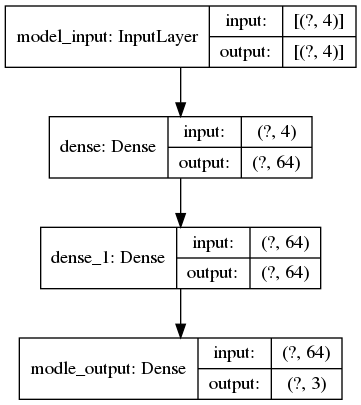

In [16]:
plot_model(dynamic, to_file='mlp-model.png', show_shapes=True)

## Setup Training:
Takes as input the current state, next state and compute both the actual state difference and the predicted state difference and predicted next state, and returns the loss and optimizer for training the dynamics model.

1. The loss function is the mean-squared-error between the normalized state difference and normalized predicted state difference
2. Create the optimizer by minimizing the loss using the Adam optimizer with learning rate
3. Compile the model

In [21]:
# Define the loss function
loss_object = tf.keras.losses.MeanSquaredError()
# Create the optimizer by minimizing the loss using the Adam optimizer with learning rate
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)
## Compile the model
dynamic.compile(optimizer=optimizer,
                loss=loss_object,
                metrics=['accuracy'])

## Training Dynamics Function
<img src=img/notebook2/1.png width="400">

1. Normalize both the states and actions in this buffer
2. Concatenate the normalized state and action
3. Pass the concatenated, normalized state-action tensor through a neural network. The resulting output is the normalized predicted difference between the next state and the current state
4. Compute the actual state difference
5. Normalize the state difference
6. return the normalized state difference as labels and the normalized state-action tensor as features

**Note in order to produce the predicted next state you need to unnormalize the delta state prediction, and add it to the current state**

In [17]:
def tf_dataset(states, actions, rewards, next_states, dones):
    # Normalize both the states and actions in this buffer
    states_norm = ml2_utils.normalize(states, random_dataset.state_mean,   random_dataset.state_std)
    actions_norm = ml2_utils.normalize(actions, random_dataset.action_mean,random_dataset.action_std)
    input_layer = tf.concat([states_norm, actions_norm], axis=1)
    # the actual state difference
    diff = next_states - states
    # Normalize it by using the statistics random_dataset and normalize function
    diff_norm = ml2_utils.normalize(diff, random_dataset.delta_state_mean, random_dataset.delta_state_std)
    yield input_layer,diff_norm

In [18]:
dataset_tf = tf.data.Dataset.from_generator(tf_dataset, 
                                            output_types =(tf.float64,tf.float64),
                                            output_shapes = (tf.TensorShape([None,4]), tf.TensorShape([None,3])),
                                            args = (random_dataset.list_2_np()),
                                            ).unbatch()

batch_size = 200
batched_dataset_tf = dataset_tf.batch(batch_size=batch_size)

In [19]:
valid_dataset_tf = tf.data.Dataset.from_generator(tf_dataset, 
                                            output_types =(tf.float64,tf.float64),
                                            output_shapes = (tf.TensorShape([None,4]), tf.TensorShape([None,3])),
                                            args = (valid_dataset.list_2_np())
                                            )

In [ ]:
#for batch, (x,y) in enumerate(valid_dataset_tf):
#    pass
#print(x,y)

In [22]:
hist = {}
hist["model"] = dynamic.fit(batched_dataset_tf,
                            epochs=10,
                            validation_data= valid_dataset_tf,
                            verbose=1)

Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.4670 - accuracy: 0.8156 - val_loss: 0.3696 - val_accuracy: 0.8480
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.1480 - accuracy: 0.8901 - val_loss: 0.0380 - val_accuracy: 0.9455
Epoch 3/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.9464 - val_loss: 0.0118 - val_accuracy: 0.9400
Epoch 4/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0114 - accuracy: 0.9597 - val_loss: 0.0062 - val_accuracy: 0.9605
Epoch 5/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 0.9695 - val_loss: 0.0036 - val_accuracy: 0.9730
Epoch 6/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 0.9745 - val_loss: 0.0022 - val_accuracy: 0.9760
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 0.9764 - val_loss: 0.0015 - val_accuracy: 0.9780
Epoch 

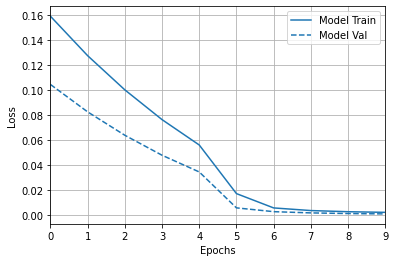

In [23]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=1)
plotter.plot(hist)

### Model Evaluation

In [24]:
# Reset the environment:
init_state = env.reset()
# Define a random policy
policy = RandomPolicy(env)
# Evaluate the model for H-step in the future 
horizon= 10

Run a random action sequence in the model

In [25]:
pred_state_seq = [init_state]
state = init_state
for i in range(horizon):
    action = policy.get_action(state)
    # Normailize the state and the action
    states_norm = ml2_utils.normalize(state, random_dataset.state_mean,   random_dataset.state_std)
    actions_norm = ml2_utils.normalize(action, random_dataset.action_mean,random_dataset.action_std)
    input_layer = tf.concat([states_norm, actions_norm], axis=0)
    # The resulting output is the normalized predicted difference between the next state and the current state
    pred_diff_norm = dynamic.predict(tf.expand_dims(input_layer,0))
    # The next State
    next_state = state + ml2_utils.unnormalize(pred_diff_norm, random_dataset.delta_state_mean,random_dataset.delta_state_std)
    state = next_state[0]
    pred_state_seq.append(state)

# convert to numpy array
pred_state_seq = np.asarray(pred_state_seq)

Run a random  action sequence on the real system

In [26]:
state_seq = [init_state]
state = init_state
for i in range(horizon):
    action = policy.get_action(state)
    state, reward, done , _ = env.step(action)
    state_seq.append(state)
    env.render()

env.close()
# convert to numpy array
state_seq = np.asarray(state_seq)

Plot the result

/home/daaboul/.Envs/venv_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


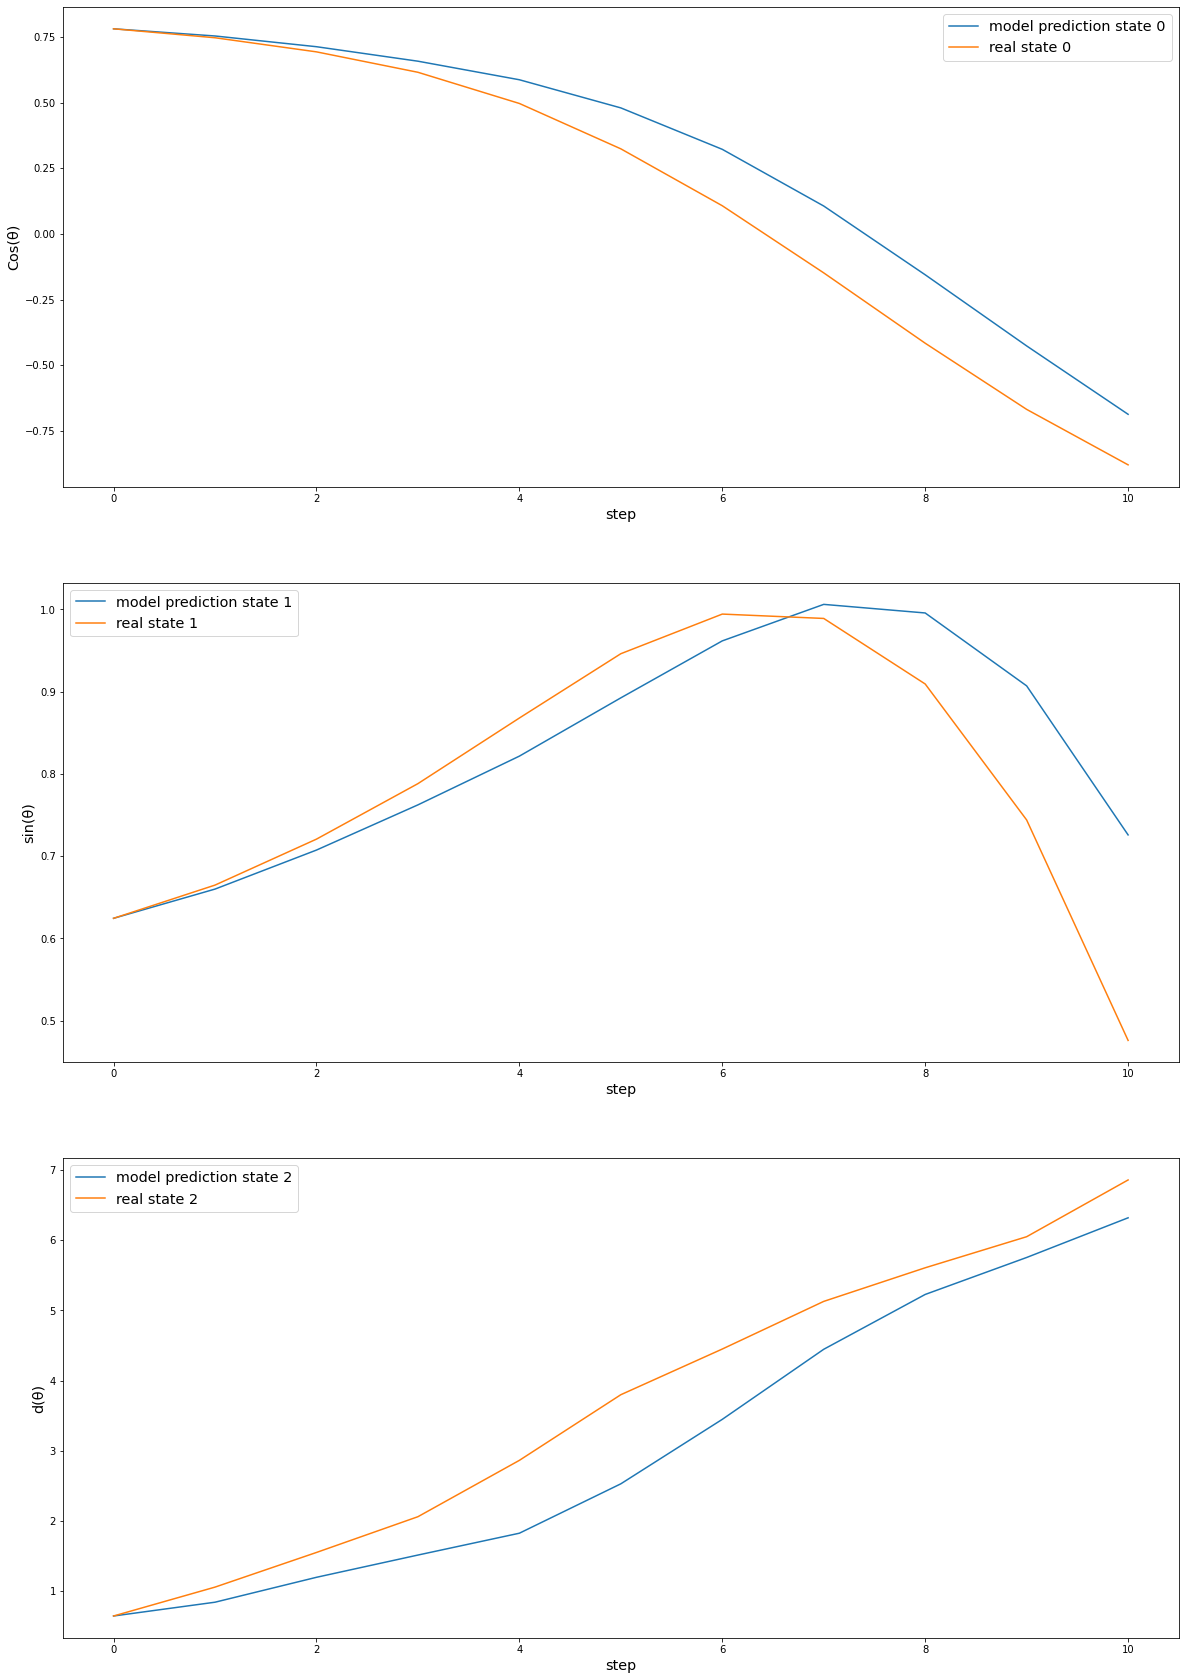

In [27]:
import matplotlib.pyplot as plt
# gripper position evaluation
#resulting_states_list = np.rollaxis(np.array(resulting_states_list), 1)
fig1, (ax1, ax2, ax3) = plt.subplots(figsize=(20,30), nrows=3, ncols=1)

# plot the predicted state
ax1.plot(np.arange(horizon+1), pred_state_seq[:,0], label='model prediction state 0')
ax2.plot(np.arange(horizon+1), pred_state_seq[:,1], label='model prediction state 1')
ax3.plot(np.arange(horizon+1), pred_state_seq[:,2], label='model prediction state 2')

# plot real values
ax1.plot(np.arange(horizon+1), state_seq[:,0], label='real state 0')
ax2.plot(np.arange(horizon+1), state_seq[:,1], label='real state 1')
ax3.plot(np.arange(horizon+1), state_seq[:,2], label='real state 2')

# set axis lables
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('step',fontsize='x-large')
ax1.set_ylabel('Cos(θ)' ,fontsize='x-large')
ax2.set_ylabel('sin(θ)' ,fontsize='x-large')
ax3.set_ylabel('d(θ)'   ,fontsize='x-large')

# plot legend
ax1.legend(loc='best',fontsize='x-large')
ax2.legend(loc='best',fontsize='x-large')
ax3.legend(loc='best',fontsize='x-large')
fig1.show()

## Action Selection
Given the learned dynamics model, we now want to select and execute actions that maximize a known reward function
$$ a^*_t = \arg \max_{a_t} \sum_{t'=t}^{t+H-1} r(\hat{s}_{t'},a_{t'})$$
$$\text{s.t.}\; \hat{s}_{t'+1} = \hat{s}_{t'} + f_\theta ( \hat{s}_{t'}, a_t)$$

However, solving this Equation is impractical because the learned dynamics model is imperfect, so using it to plan in such an open-loop manner will lead to accumulating errors over time and planning far into the future will become very inaccurate.

We will solve this equation using sampling method (gradient-free optimization), where we will Sample $k$ random action sequences of length $H$, then we will use the model to predict the future states by taking each of these action sequences, then we will evaluate the reward with each candidate action sequence, and the last step will be to  select the best action sequence

<img src=img/notebook2/2.png width="400">

1. Randomly sample uniformly num_random_action_selection number of action sequences, each of length mpc_horizon
2. Starting from the input state, unroll each action sequence using your neural network dynamics model
3. While unrolling the action sequences, keep track of the cost of each action sequence using cost_fn
4. Find the action sequence with the lowest cost, and return the first action in that sequence

In [28]:
num_random_action_selection= 3000
mpc_horizon=10
action_dim       = env.action_space.shape[0]
action_space_low = env.action_space.low
action_space_high= env.action_space.high 
actions = tf.random.uniform(
            shape=[num_random_action_selection, mpc_horizon, action_dim],
            minval=action_space_low,
            maxval=action_space_high,
            dtype=tf.float64
        )
print("The Shape of Actions: ", actions.shape)
print("The first Sample: ", actions[0])

The Shape of Actions:  (3000, 10, 1)
The first Sample:  tf.Tensor(
[[-0.42298146]
 [ 0.88883983]
 [ 1.1236848 ]
 [-1.29204569]
 [ 1.94369085]
 [-0.73081327]
 [-0.55167003]
 [ 1.02275115]
 [-0.36573572]
 [-0.60605947]], shape=(10, 1), dtype=float64)


In [29]:
# Define the Cost
costs = tf.zeros(num_random_action_selection, dtype=tf.float64)
print("The Shape of costs: ", costs.shape)

The Shape of costs:  (3000,)


In [30]:
init_state = env.reset()
states = tf.stack([init_state] * num_random_action_selection)
print("The Shape: ", states.shape)
states

The Shape:  (3000, 3)


<tf.Tensor: shape=(3000, 3), dtype=float64, numpy=
array([[-0.22629684,  0.97405839, -0.81242461],
       [-0.22629684,  0.97405839, -0.81242461],
       [-0.22629684,  0.97405839, -0.81242461],
       ...,
       [-0.22629684,  0.97405839, -0.81242461],
       [-0.22629684,  0.97405839, -0.81242461],
       [-0.22629684,  0.97405839, -0.81242461]])>

In [31]:
def cost_fun(states,actions):
    costh = states[:,0]
    sinth = states[:,1]
    thdot = states[:,2]
    th = np.arctan2(sinth,costh)
    th_normalize = (((th+np.pi) % (2*np.pi)) - np.pi)
    action = np.clip(actions,-2.0, 2.0)[0]
    costs = (th_normalize ** 2 + .1 * thdot ** 2 + .001 * (action ** 2))
    return costs

planning in the model:

In [32]:
init_state = env.reset()
states = tf.stack([init_state] * num_random_action_selection)
for t in range(mpc_horizon):
    states_norm = ml2_utils.normalize(states, random_dataset.state_mean,   random_dataset.state_std)
    actions_norm = ml2_utils.normalize(actions[:, t, :], random_dataset.action_mean,random_dataset.action_std)
    input_layer = tf.concat([states_norm,actions_norm ], axis=1)
    # The resulting output is the normalized predicted difference between the next state and the current state
    pred_diffs_norm = dynamic.predict(input_layer)
    # calculate the cost
    costs +=cost_fun(states, actions[:, t, :])
    # The next State
    next_states = states + ml2_utils.unnormalize(pred_diffs_norm, random_dataset.delta_state_mean,random_dataset.delta_state_std)
    states = next_states
# optimal sequence of actions
action_seq  = actions[tf.argmin(costs)]
# the first action that minimizes the cost function
best_action = action_seq[0]

Run the optimal action sequence in the model (for evaluation)

In [33]:
# convert to numpy array
pred_state_seq = np.asarray(pred_state_seq)
pred_state_seq = [init_state]
state = init_state
for action in action_seq:
    # Normailize the state and the action
    state_norm = ml2_utils.normalize(state, random_dataset.state_mean,   random_dataset.state_std)
    action_norm = ml2_utils.normalize(action, random_dataset.action_mean,random_dataset.action_std)
    input_layer = tf.concat([state_norm, action_norm], axis=0)

    # The resulting output is the normalized predicted difference between the next state and the current state
    pred_diff_norm = dynamic.predict(tf.expand_dims(input_layer,0))
    # The next State
    next_state = state + ml2_utils.unnormalize(pred_diff_norm, random_dataset.delta_state_mean,random_dataset.delta_state_std)
    state = next_state[0]
    pred_state_seq.append(state)

# convert to numpy array
pred_state_seq = np.asarray(pred_state_seq)

Run the optimal action sequence on the real system
<img src=img/notebook2/3.png width="400">

In [36]:
state_seq = [init_state]
state = init_state
for action in action_seq:
    state, reward, done , _ = env.step(action)
    state_seq.append(state)
    env.render()
    
# convert to numpy array
state_seq = np.asarray(state_seq)
env.close()

/home/daaboul/.Envs/venv_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


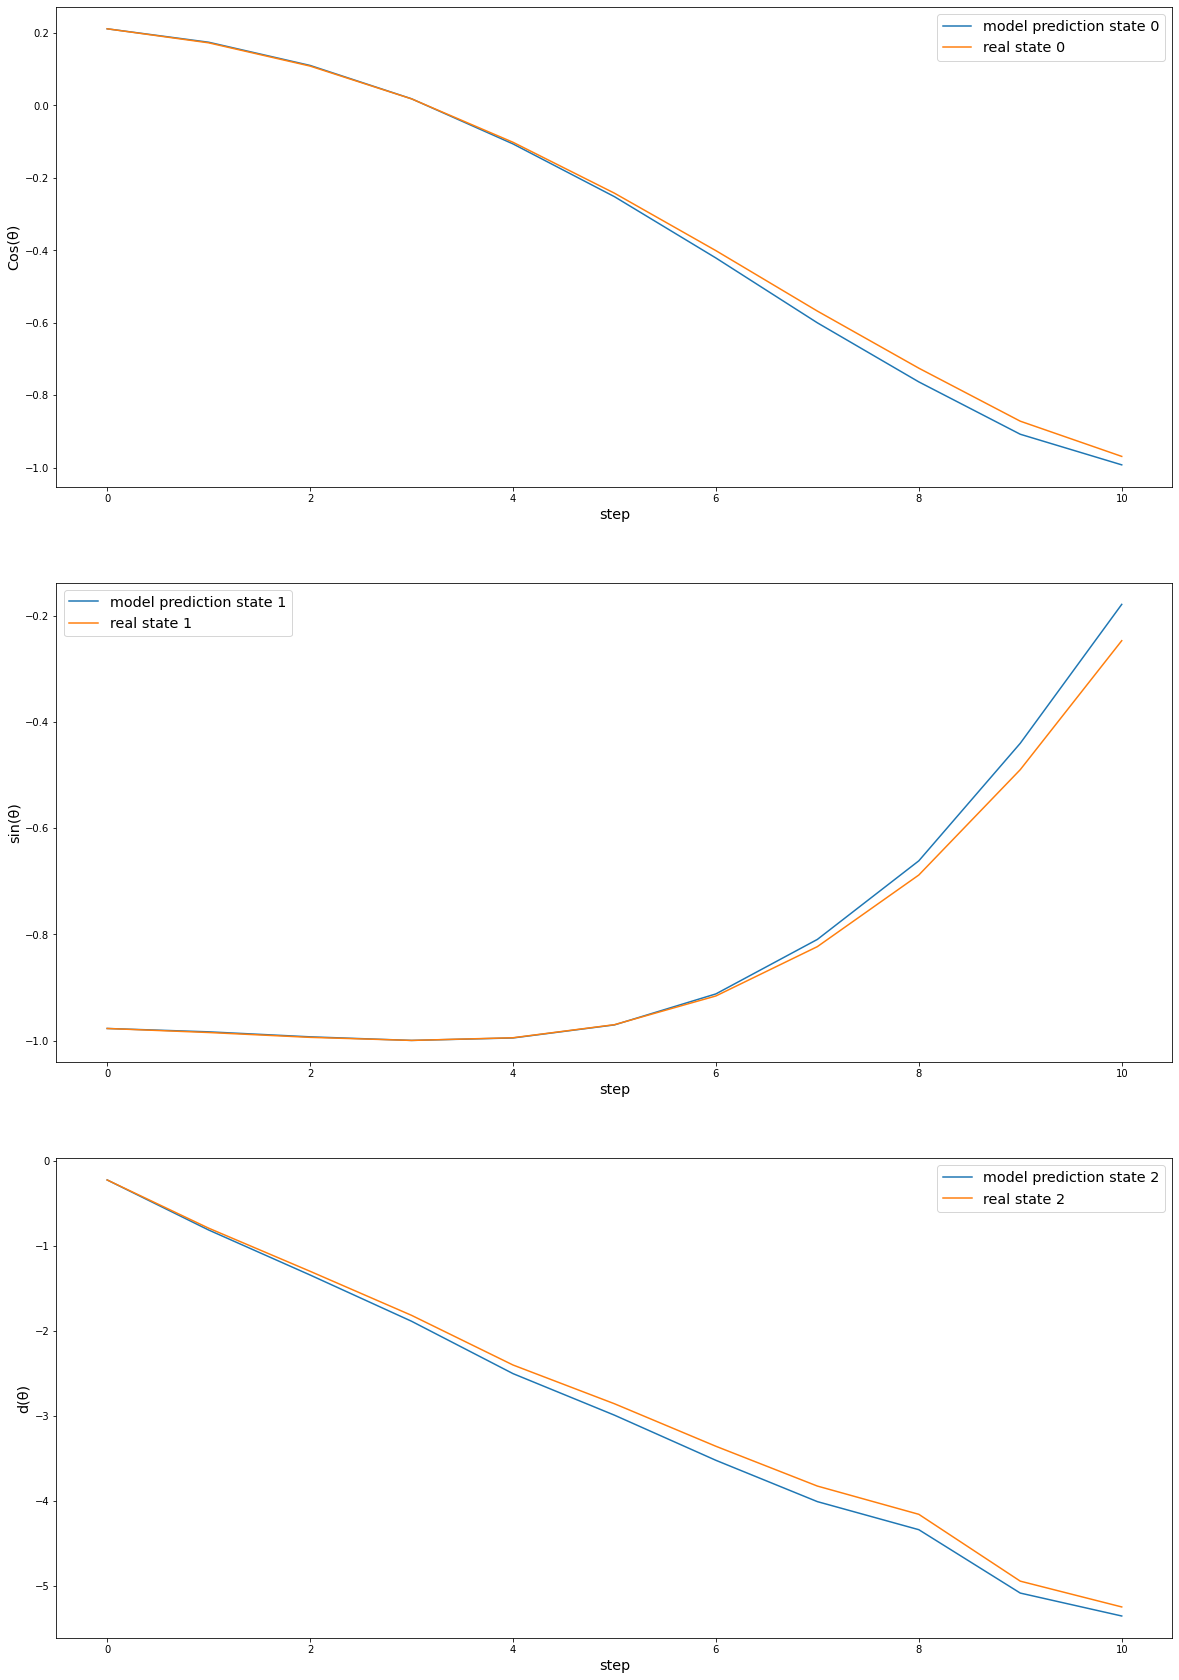

In [35]:
import matplotlib.pyplot as plt
# gripper position evaluation
#resulting_states_list = np.rollaxis(np.array(resulting_states_list), 1)
fig1, (ax1, ax2, ax3) = plt.subplots(figsize=(20,30), nrows=3, ncols=1)

# plot the predicted state
ax1.plot(np.arange(mpc_horizon+1), pred_state_seq[:,0], label='model prediction state 0')
ax2.plot(np.arange(mpc_horizon+1), pred_state_seq[:,1], label='model prediction state 1')
ax3.plot(np.arange(mpc_horizon+1), pred_state_seq[:,2], label='model prediction state 2')

# plot real values
ax1.plot(np.arange(mpc_horizon+1), state_seq[:,0], label='real state 0')
ax2.plot(np.arange(mpc_horizon+1), state_seq[:,1], label='real state 1')
ax3.plot(np.arange(mpc_horizon+1), state_seq[:,2], label='real state 2')

# set axis lables
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('step',fontsize='x-large')
ax1.set_ylabel('Cos(θ)' ,fontsize='x-large')
ax2.set_ylabel('sin(θ)' ,fontsize='x-large')
ax3.set_ylabel('d(θ)'   ,fontsize='x-large')

# plot legend
ax1.legend(loc='best',fontsize='x-large')
ax2.legend(loc='best',fontsize='x-large')
ax3.legend(loc='best',fontsize='x-large')
fig1.show()

In [ ]:
## Not Importent
state = env.reset()
for i in range(10):
    actions = tf.random.uniform(
            shape=[num_random_action_selection, mpc_horizon, action_dim],
            minval=action_space_low,
            maxval=action_space_high,
            dtype=tf.float64
        )
    init_state = state
    states = tf.stack([init_state] * num_random_action_selection)
    costs = 0
    
    # find the optimal action sequence 
    for t in range(mpc_horizon):
        # Normailize the state and the action
        states_norm = ml2_utils.normalize(states, random_dataset.state_mean,   random_dataset.state_std)
        actions_norm = ml2_utils.normalize(actions[:, t, :], random_dataset.action_mean,random_dataset.action_std)
        input_layer = tf.concat([states_norm, actions_norm], axis=1)
        # The resulting output is the normalized predicted difference between the next state and the current state
        pred_diffs_norm = dynamic.predict(input_layer)
        # calculate the cost
        costs +=cost_fun(states, actions[:, t, :])                    
        # The next State
        next_states = states + ml2_utils.unnormalize(pred_diffs_norm, random_dataset.delta_state_mean,random_dataset.delta_state_std)
        states = next_states
    # optimal sequence of actions
    action_seq  = actions[tf.argmin(costs)]
    print("the cost of best action sequence: ", tf.reduce_min(costs))
    # the action that minimizes the cost function
    # run the action sequence on the real system
    for best_action in action_seq:    
        state, reward, done , _ = env.step(best_action)
        env.render()
        
env.close()

### Replanning:
<img src=img/notebook2/4.png width="400">

1. Execute the first planned action a_t and observe the next state s_{t+1}
2. Use model again to optimize the action sequenc a_{t+1},..., a_{t+H}


In [38]:
state = env.reset()
for i in range(50):
    actions = tf.random.uniform(
            shape=[num_random_action_selection, mpc_horizon, action_dim],
            minval=action_space_low,
            maxval=action_space_high,
            dtype=tf.float64
        )
    init_state = state
    states = tf.stack([init_state] * num_random_action_selection)
    costs = 0
    
    # find the optimal action sequence 
    for t in range(mpc_horizon):
        # Normailize the state and the action
        states_norm = ml2_utils.normalize(states, random_dataset.state_mean,   random_dataset.state_std)
        actions_norm = ml2_utils.normalize(actions[:, t, :], random_dataset.action_mean,random_dataset.action_std)
        input_layer = tf.concat([states_norm, actions_norm], axis=1)
        # The resulting output is the normalized predicted difference between the next state and the current state
        pred_diffs_norm = dynamic.predict(input_layer)
        # calculate the cost
        costs +=cost_fun(states, actions[:, t, :])                    
        # The next State
        next_states = states + ml2_utils.unnormalize(pred_diffs_norm, random_dataset.delta_state_mean,random_dataset.delta_state_std)
        states = next_states
    #action_seq  = actions[tf.argmax(costs)]
    print("the cost of best action sequence: ", tf.reduce_min(costs))
    # the action that minimizes the cost function
    best_action = actions[tf.argmin(costs)][0]
    # run the actions on the real system
    
    state, reward, done , _ = env.step(best_action)
    env.render()

the cost of best action sequence:  tf.Tensor(41.99622656338429, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(48.532687729040596, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(54.62325420045428, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(65.47841386876297, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(73.60620764426722, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(79.71907251722034, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(83.04894405595803, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(85.23178932089166, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(84.73456475493255, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(82.14164870668196, shape=(), dtype=float64)
the cost of best action sequence:  tf.Tensor(77.24631439354373, shape=(), dtype=float64)
the cost of best act

In [ ]:
env.close()